In [98]:

from find_prices_nonoverlap import *
from sklearn import metrics
from sklearn.model_selection import (GridSearchCV, StratifiedKFold, cross_val_score)

In [96]:
from sklearn.ensemble import AdaBoostRegressor

Setting up pipeline
Fitting data
Evaluating model on training data
116308.349785
71586.3535556
0.11497911202


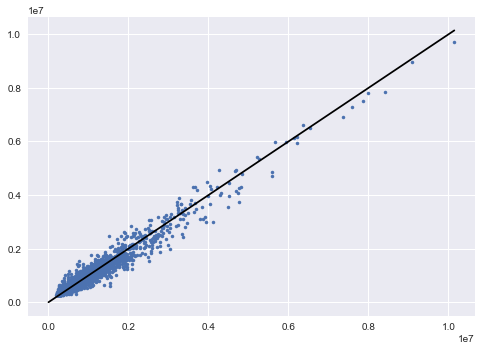

Evaluating model on testing data
142215.663493
78197.7964094
0.91105154072
0.117098305211


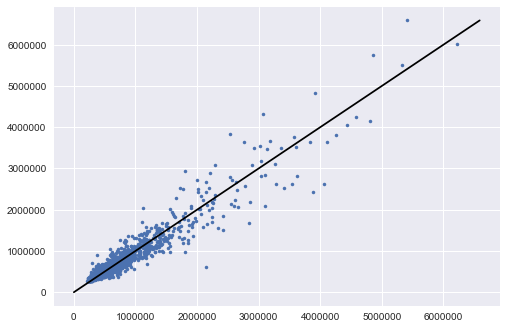

In [107]:
import warnings
warnings.filterwarnings(action='once')
from sklearn.ensemble import (
    ExtraTreesRegressor, GradientBoostingRegressor 
)

print("Setting up pipeline")
features = ('latitude', 'longitude',# 'zipcode',
            'bedrooms', 'bathrooms','rooms', 
            'squareFootage', 'lotSize', 
            'yearBuilt',
            'lastSaleAmount','lastSaleDateYear','lastSaleDateMonth','lastSaleDateDayOfWeek')
#'yearBuilt', 'lastSaleDayOfWeek','lastSaleWeekOfYear','lastSaleMonth','LastSaleYear',
# features = required_fields

#: Note imputer will strip away column heads, it has to be after featurize
# reg_function = LGBMRegressor()
#reg_function = XGBRegressor()
reg_function = RandomForestRegressor(n_jobs=3)
reg_function = GradientBoostingRegressor()
# reg_function = ExtraTreesRegressor(n_estimators=2)
# reg_function = AdaBoostRegressor(); #Really bad
pipeline = Pipeline([
          ('featurize', featurize(features)),
          ('imputer', Imputer(missing_values=np.nan, strategy="mean", axis=0)),
          ('forest', reg_function,)
            ])

print("Fitting data")
X = df_train[df_train.columns.drop('estimated_value')]
y = df_train['estimated_value']
model = pipeline.fit(X = X, y = y)

print("Evaluating model on training data")
y_pred = model.predict(X)
print(np.sqrt(metrics.mean_squared_error(y,y_pred)))
print(metrics.mean_absolute_error(y,y_pred))
print(abs_mean_relative_error(y,y_pred))

plt.plot(y, y_pred,'.')
y_max = np.max((y, y_pred))
plt.plot((0,y_max), (0,y_max),color='black')
plt.show()
print("Evaluating model on testing data")
X = X_test
y=y_test
y_pred = model.predict(X)
print(np.sqrt(metrics.mean_squared_error(y,y_pred)))
print(metrics.mean_absolute_error(y,y_pred))
print(metrics.r2_score(y,y_pred))
print(abs_mean_relative_error(y,y_pred))
plt.plot(y, y_pred,'.')
y_max = np.max((y, y_pred))
plt.plot((0,y_max), (0,y_max),color='black')
plt.show()

In [85]:
#: Work on using grid-searches
params = {'forest__n_estimators':  (39,42)}
# params = {'forest__n_estimators':  np.arange(3,31,3)}
grid = GridSearchCV(pipeline, params)
grid.fit(X = X, y = y)

#: Definining a specified cross-validation technique
cv= StratifiedKFold(n_splits=2)

# Alternatively, can say can say cv=3 to say a 3-repeat cross-validator
grid_search = GridSearchCV(pipeline, params, cv=cv)
#gsearch = GridSearchCV(pipeline, params)
grid_search.fit(X = X, y = y)
best_pipeline = grid_search.best_estimator_
best_pipeline.get_params()['forest']

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('featurize', DataFrameMapper(default=False, df_out=False,
        features=[('latitude', StandardScaler(copy=True, with_mean=True, with_std=True)), ('bedrooms', StandardScaler(copy=True, with_mean=True, with_std=True)), ('bathrooms', StandardScaler(copy=True, with_mean=True, with_std=True)),...timators=10, n_jobs=3, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'forest__n_estimators': (39, 42)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [86]:
best_pipeline = grid_search.best_estimator_
best_pipeline.get_params()['forest']

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=39, n_jobs=3, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [60]:
# cross_val_score(pipeline, X, y, 'accuracy')

138356.548905
69145.2873062
0.915813392763
0.097923132224


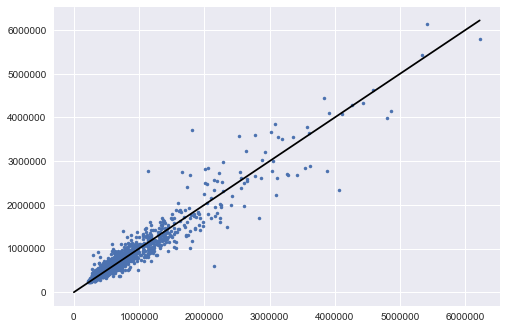

In [103]:
X = X_test
y=y_test
y_pred = best_pipeline.predict(X)
print(np.sqrt(metrics.mean_squared_error(y,y_pred)))
print(metrics.mean_absolute_error(y,y_pred))
print(metrics.r2_score(y,y_pred))
print(abs_mean_relative_error(y,y_pred))
plt.plot(y, y_pred,'.')
y_max = np.max((y, y_pred))
plt.plot((0,y_max), (0,y_max),color='black')
plt.show()

In [83]:
grid_search.cv_results_

{'mean_fit_time': array([ 0.63398258,  0.69698826]),
 'mean_score_time': array([ 0.12484566,  0.12942346]),
 'mean_test_score': array([ 0.90950593,  0.90377831]),
 'mean_train_score': array([ 0.98421428,  0.9839824 ]),
 'param_forest__n_estimators': masked_array(data = [39 42],
              mask = [False False],
        fill_value = ?),
 'params': ({'forest__n_estimators': 39}, {'forest__n_estimators': 42}),
 'rank_test_score': array([1, 2], dtype=int32),
 'split0_test_score': array([ 0.9100328 ,  0.90423674]),
 'split0_train_score': array([ 0.98456705,  0.98444663]),
 'split1_test_score': array([ 0.90946526,  0.90501357]),
 'split1_train_score': array([ 0.9846554,  0.9836217]),
 'split2_test_score': array([ 0.90901955,  0.90208406]),
 'split2_train_score': array([ 0.98342038,  0.98387888]),
 'std_fit_time': array([ 0.00613244,  0.08328097]),
 'std_score_time': array([ 0.0057937 ,  0.00588672]),
 'std_test_score': array([ 0.00041464,  0.00123909]),
 'std_train_score': array([ 0.000562

array([ 0.04017623,  0.0076597 ,  0.01322584,  0.00625052,  0.50421751,
        0.04099022,  0.38747999])

In [ ]:
pipeline.steps[2][1].feature_importances_